In [2]:
import os
from glob import glob

import numpy as np
from matplotlib import pyplot as plt

plt.rcParams.update({"font.size": 27})

# Folder with data for TDC calibration: sensor under ambient light
os.chdir(r"D:\LinoSPAD2\Data\B7d\2024.10.14\TDC_calib_2212b")
files = glob("*.dat")

timestamps = 1000
firmware_version = "2212b"

# List of raw codes from all files
counts_all = []

# Go over all files in the folder, collect the histogram counts of
# raw TDC codes
for file in files:

    # Unpack binary data
    raw_data = np.fromfile(file, dtype=np.uint32)
    # Timestamps are stored in the lower 28 bits
    data_timestamps = (raw_data & 0xFFFFFFF).astype(np.int64)
    # Pixel address in the given TDC is 2 bits above timestamp
    data_pixels = ((raw_data >> 28) & 0x3).astype(np.int8)
    # Check the top bit, assign '-1' to invalid timestamps
    data_timestamps[raw_data < 0x80000000] = -1
    # Free up memory
    del raw_data

    # Number of acquisition cycles in each data file
    cycles = len(data_timestamps) // (timestamps * 65)
    # Transform into a matrix of size 65 by cycles*timestamps
    data_pixels = (
        data_pixels.reshape(cycles, 65, timestamps)
        .transpose((1, 0, 2))
        .reshape(65, -1)
    )

    data_timestamps = (
        data_timestamps.reshape(cycles, 65, timestamps)
        .transpose((1, 0, 2))
        .reshape(65, -1)
    )

    if firmware_version == "2212s":
        pix_coor = np.arange(256).reshape(4, 64).T
    if firmware_version == "2212b":
        pix_coor = np.arange(256).reshape(64, 4)

    # Find the corresponding TDC for the requested pixel
    pixel = 100
    tdc2, _ = np.argwhere(pix_coor == pixel)[0]

    # Select data from the TDC
    data_to_plot = data_timestamps[tdc2]

    # Convert to TDC raw code
    data_to_plot = data_to_plot[data_to_plot > 0] % 140
    
    # Histogram of raw codes    
    bins = np.arange(0, 141, 1)

    counts, _ = np.histogram(data_to_plot, bins=bins)

    counts_all.append(counts)

Each TDC outputs a histogram $H_{\mathrm{in}}$ of 140 bins (35 tap-delay line elements of 4 bits each), covering at least $\tau_{\mathrm{TDC}} = 2.5$ ns (from the 400 MHz sampling clock). Each bin has a size $S_{\mathrm{in}, i}$ and position $P_{\mathrm{in}, i}$, where index "in" stands for initial.

The size and the position are calculated using the histogram of raw codes "counts_all":

$S_{\mathrm{in}, i} =\tau_{\mathrm{TDC}}\frac{C_\mathrm{in}, i}{\sum^{139}_{j=0}C_{\mathrm{in},j}} $;

$P_{\mathrm{in}, i} = \sum^{i-1}_{j=0}S_{\mathrm{in}, j}$.

In [3]:
# Combine all raw codes for calibration into S_in,i
counts_corr = (
    np.sum(counts_all, axis=0) / np.sum(counts_all) * 2500
)

Text(0.5, 1.0, 'Ideal TDC (green) vs Real TDC (red)')

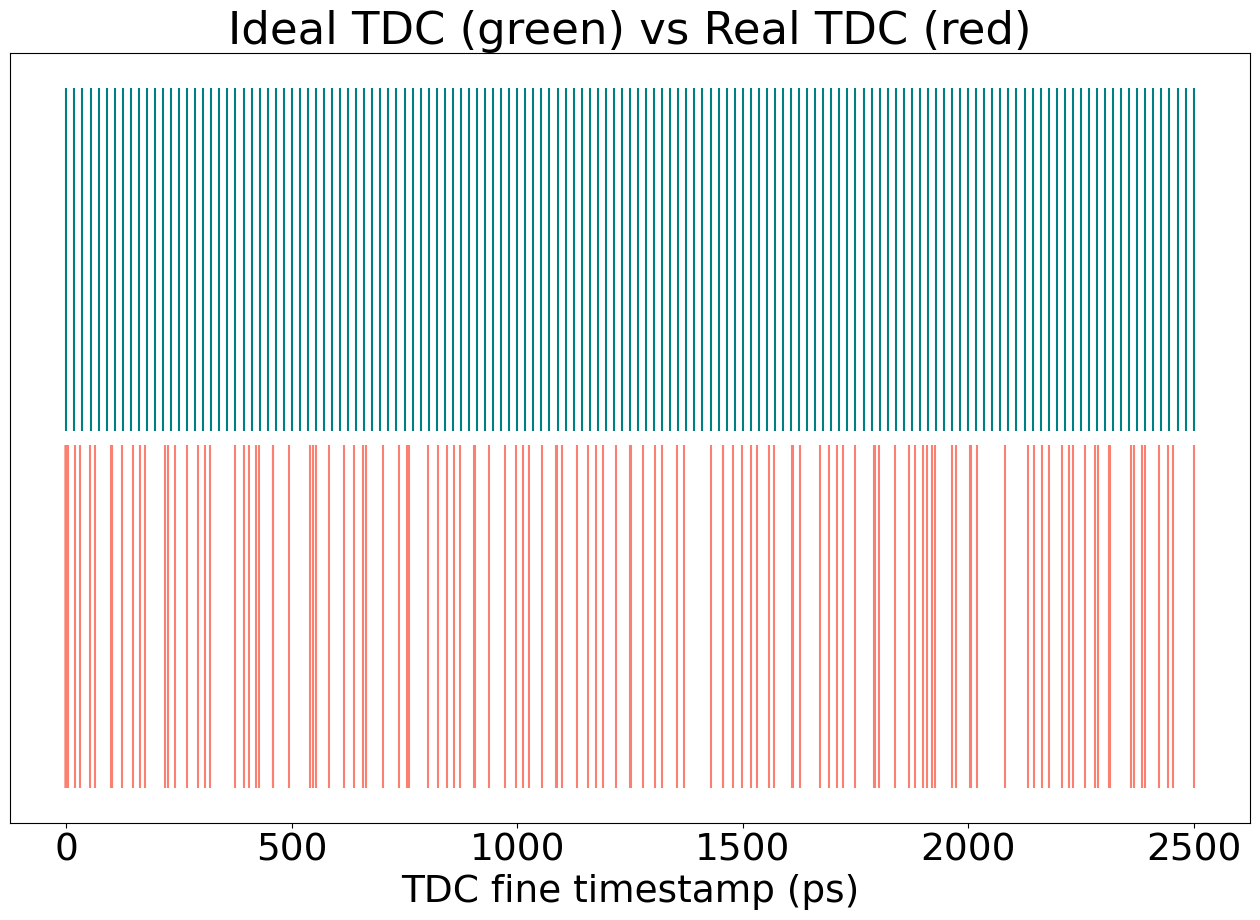

In [4]:
# Real vs ideal binning
plt.figure(figsize=(16, 10))
plt.vlines(np.cumsum(counts_corr), 0, 0.49, color="salmon")
plt.vlines([x * 2500 / 140 for x in range(141)], 0.51, 1, color="teal")
plt.xlabel("TDC fine timestamp (ps)")
plt.yticks([], [])
plt.title("Ideal TDC (green) vs Real TDC (red)")

Text(0.5, 1.0, 'LinoSPAD2 TDC density plot')

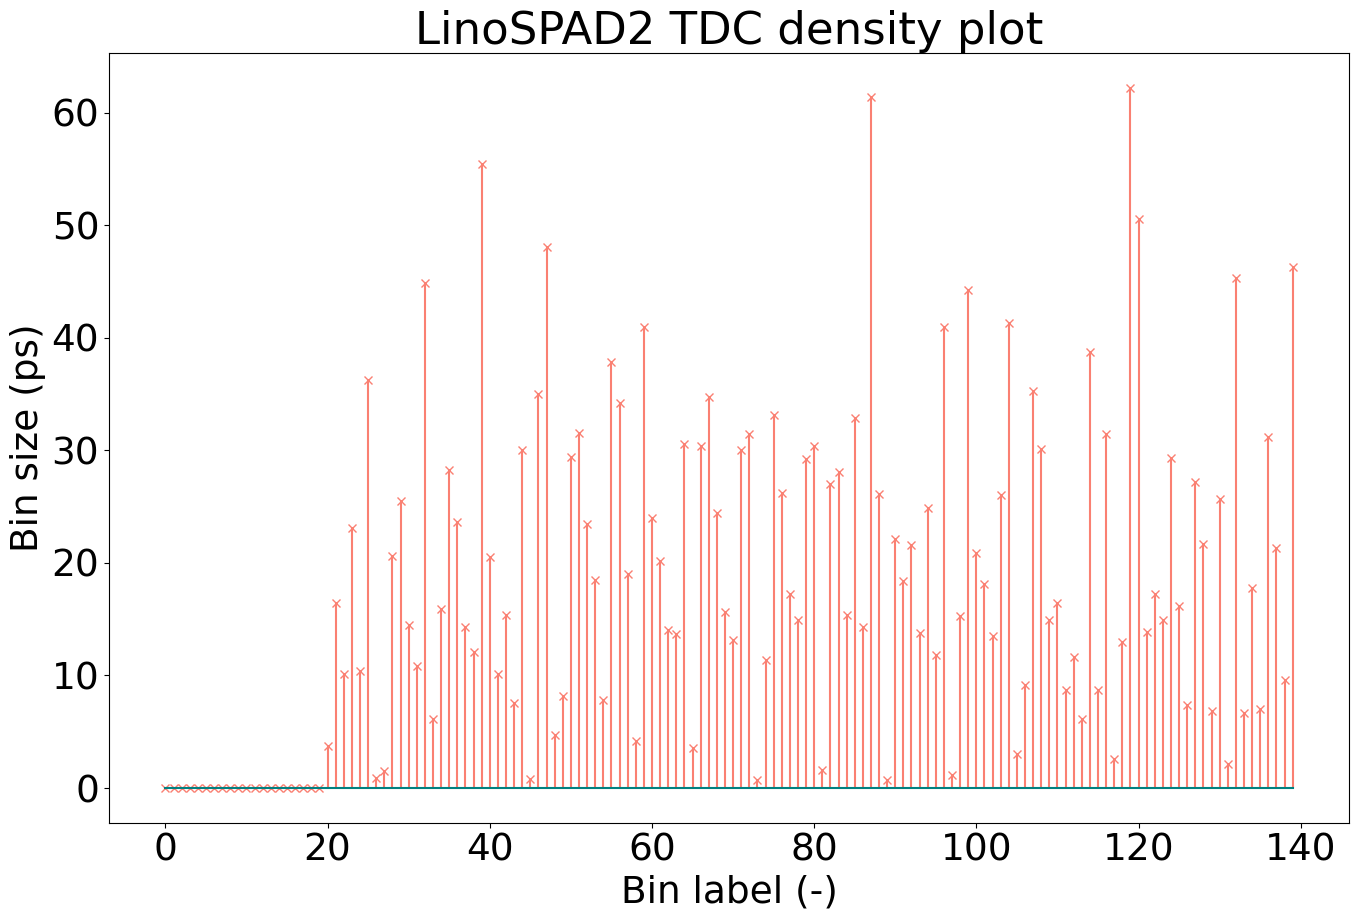

In [5]:
# TDC density plot
plt.figure(figsize=(16, 10))
plt.stem(
    counts_corr,
    markerfmt="x",
    basefmt="teal",
    linefmt="salmon",
)
plt.xlabel("Bin label (-)")
plt.ylabel("Bin size (ps)")
plt.title("LinoSPAD2 TDC density plot")

Because the TDC is designed in a way so that it covers at least the 2.5 ns coming from the sampling clock of 400 MHz, not all bins are used, which are shown as bin with 0 ps bin size in the plot above.

To evaluate the TDC output, differential and integral non-linearity is measured (DNL, INL).

DNL represents how much each bin deviates from the ideal bin:

$\mathrm{DNL}_{i} = \frac{W_{\mathrm{real}, i} - W_{\mathrm{ideal}}}{W_{\mathrm{ideal}}} = \frac{t_{\mathrm{in}, i+1} - t_{\mathrm{in}, i}}{W_{\mathrm{ideal}}} - 1 $,
where $t_{\mathrm{in}, i}$ is the fine timestamp of the TDC code. The difference between the two consecutive timestamp gives the width of the TDC bin.

The INL corresponds to the integral of the DNL up to the given point $i \in [1, 139]$.

$\mathrm{INL}_{\mathrm{i}} = \sum^{i}_{j=0}\mathrm{DNL}_{\mathrm{j}}$.

Text(0.5, 1.0, 'LinoSPAD2 DNL')

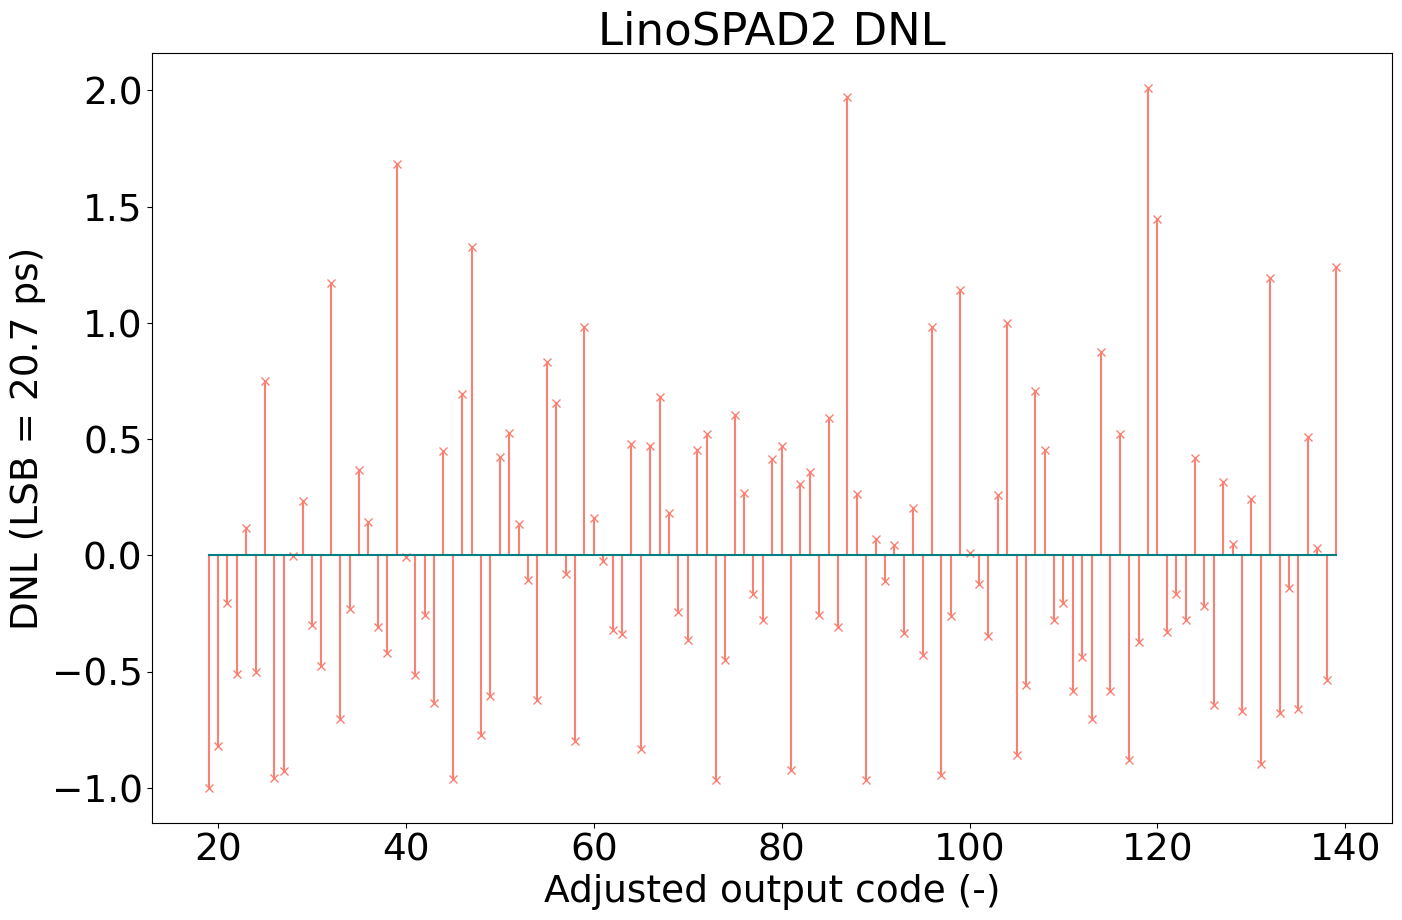

In [6]:
# LinoSPAD2 TDC DNL

# Find first nonzero element
nonzero_start_counts = np.where(counts_corr > 0)[0][0]

DNL = (
    counts_corr[nonzero_start_counts:]
    / (2500 / (140 - nonzero_start_counts))
    - 1
)

plt.figure(figsize=(16, 10))
plt.stem(
    range(nonzero_start_counts, 140),
    DNL,
    markerfmt="x",
    basefmt="teal",
    linefmt="salmon",
)
plt.xlabel("Adjusted output code (-)")
plt.ylabel(f"DNL (LSB = {2500/(140-nonzero_start_counts):.1f} ps)")
plt.title("LinoSPAD2 DNL")

Text(0.5, 1.0, 'LinoSPAD2 INL')

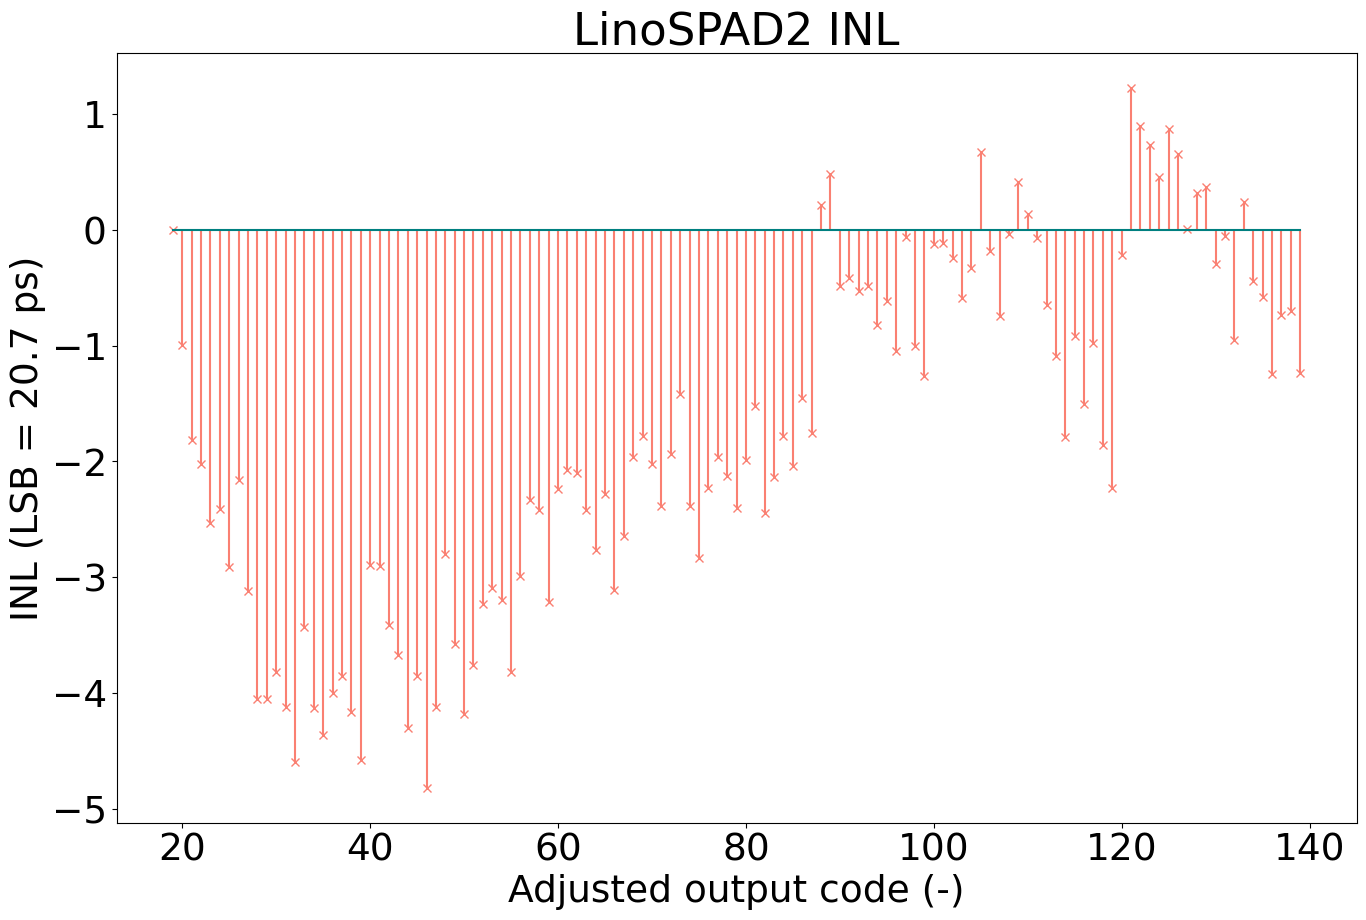

In [7]:
# LinoSPAD2 INL
INL = np.zeros(140 - nonzero_start_counts)
for i in range(len(INL)):
    INL[i] = np.sum(DNL[:i])

plt.figure(figsize=(16, 10))
plt.stem(
    range(nonzero_start_counts, 140),
    INL,
    markerfmt="x",
    basefmt="teal",
    linefmt="salmon",
)
plt.xlabel("Adjusted output code (-)")
plt.ylabel(f"INL (LSB = {2500/(140-nonzero_start_counts):.1f} ps)")
plt.title("LinoSPAD2 INL")

The nonlinearities in the DNL and INL can be corrected for using counts redistribution to bins of an ideal TDC, where TDC bins are all equally wide. To achieve that, one can apply a calibration matrix $M$ to the initial histogram $H_{\mathrm{in}}$ to get the redistributed histogram $H_{\mathrm{out}}$:

$H_{\mathrm{out}} = M \times H_{\mathrm{in}}$.

The elements of the calibration matrix can be calculated based on the positions and widths of both the real and ideal TDCs.

$M_{i, j} = max(0, \frac{min(P_{\mathrm{in}, i} + S_{\mathrm{in}, i}, \ P_{\mathrm{out}, j} + S_{\mathrm{out}}) - max(P_{\mathrm{in}, i}, \ P_{\mathrm{out}, j})}{S_{\mathrm{in}, i}})$,

where 

$S_{\mathrm{in}, i} =\tau_{\mathrm{TDC}}\frac{C_\mathrm{in}, i}{\sum^{139}_{j=0}C_{\mathrm{in},j}} $;

$P_{\mathrm{in}, i} = \sum^{i-1}_{j=0}S_{\mathrm{in}, j}$;

$S_{\mathrm{out}, j} = S_{\mathrm{out}} = \frac{\tau_{\mathrm{TDC}}}{N}$,
with $N$ is the number of actually utilized bins;

$P_{\mathrm{out}, j} = j\frac{\tau_{\mathrm{TDC}}}{N}$.

The matrix itself should be transposed after each element is calculated, since it's built to redistribute initial counts into ideal bins, while the final correction is done in the opposite direction: the ideal bins collect the fraction of initial counts using the calculated weights.

In [8]:
M = np.zeros((140 - nonzero_start_counts, 140 - nonzero_start_counts))
S_in = counts_corr

S_in_pos = S_in[nonzero_start_counts:]

S_out = 2500 / (140 - nonzero_start_counts)

for i in range(140 - nonzero_start_counts):
    P_in_i = np.sum(S_in_pos[:i])

    for j in range(140 - nonzero_start_counts):
        P_out_j = j * 2500 / (140 - nonzero_start_counts)
        stuff = (
            np.min((P_in_i + S_in_pos[i], P_out_j + S_out)) - np.max((P_in_i, P_out_j))
        ) / S_in_pos[i]

        M[i, j] = np.max((0, stuff))

M = M.T

The image below shows the princip behind the redistribution of counts. Adapted from [here](https://www.mdpi.com/2410-390X/1/1/6).


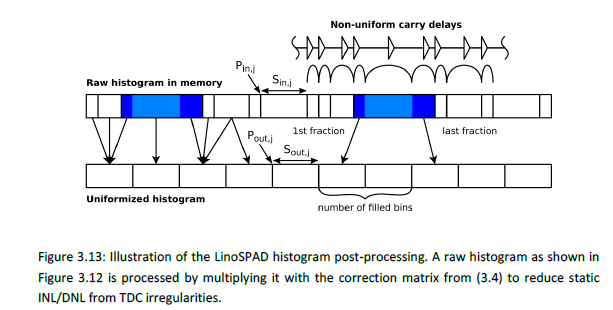

In [10]:
import base64
from IPython.display import HTML

# Open the image file in binary mode
with open(r"D:\redistribution.png", "rb") as image_file:
    # Convert the image to base64
    encoded_image = base64.b64encode(image_file.read()).decode("utf-8")

# Display the image inline in the notebook
img_html = f'<img src="data:image/png;base64,{encoded_image}" alt="Embedded Image" />'
display(HTML(img_html))


<ErrorbarContainer object of 3 artists>

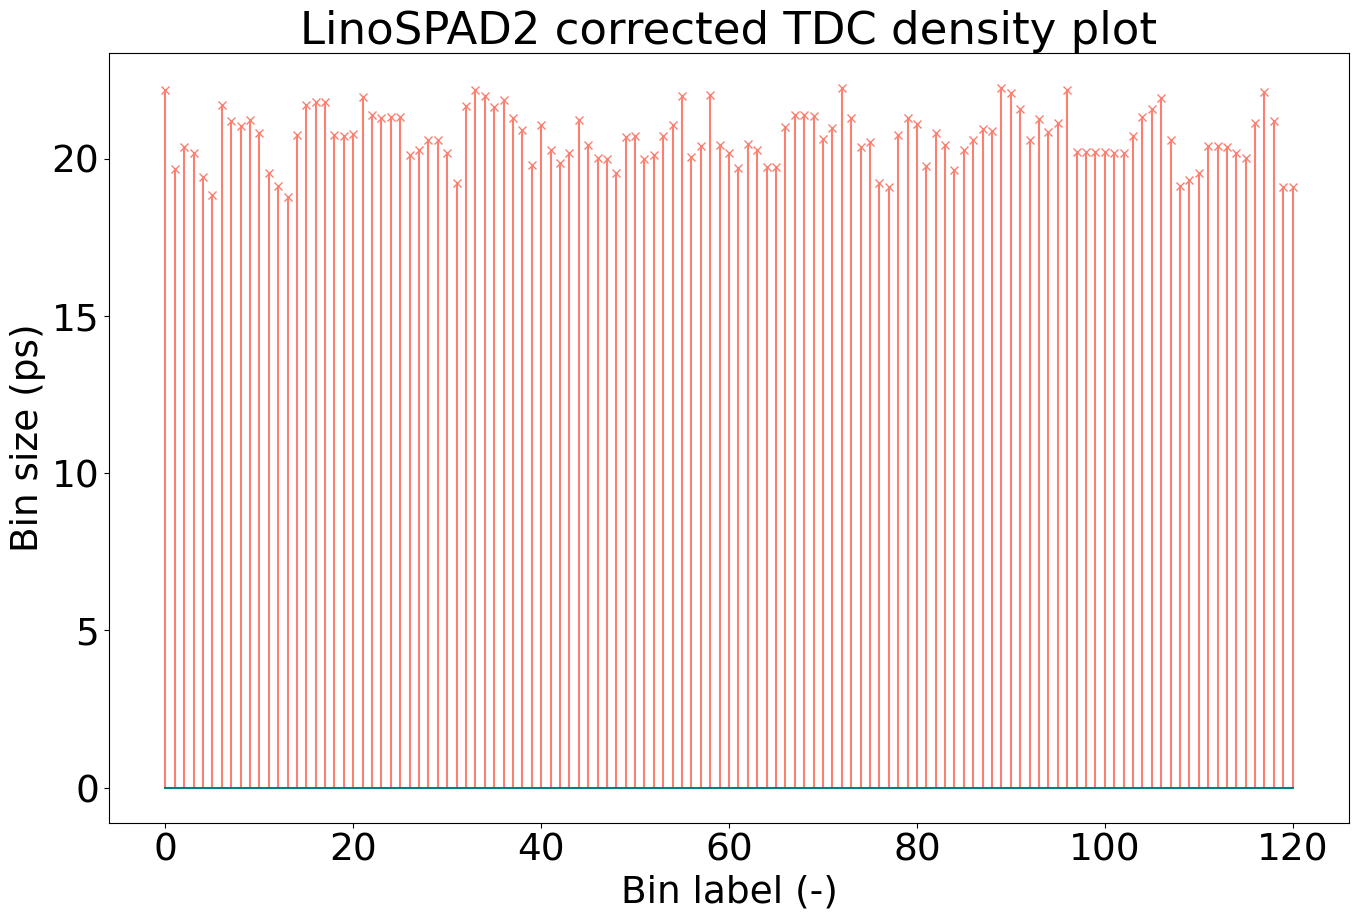

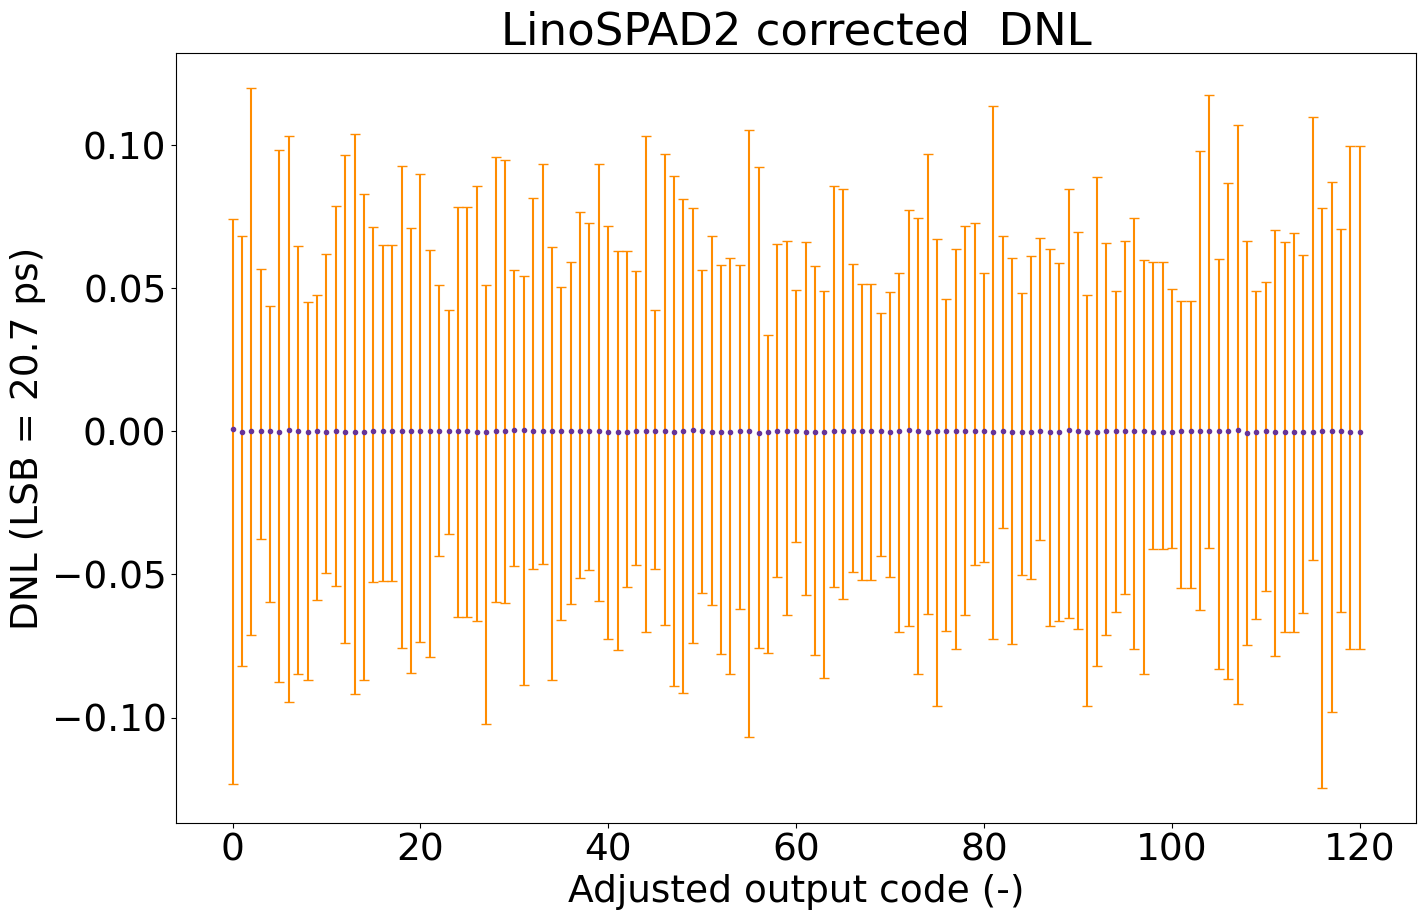

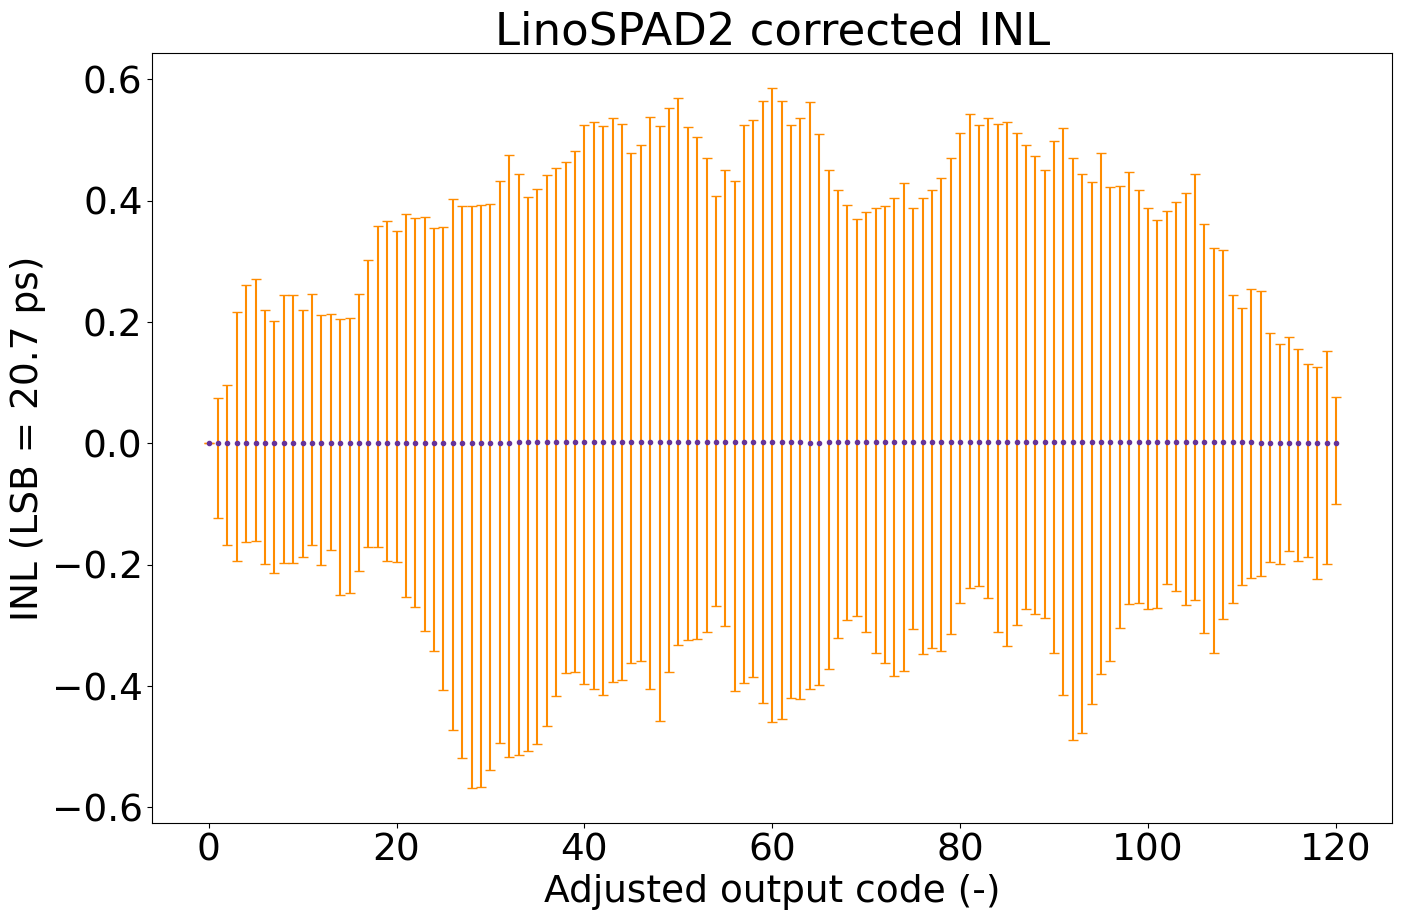

In [12]:
# Plot the corrected DNL and INL plots
DNL_calib_all = []
INL_calib_all = []

for i in range(len(counts_all)):
    counts_calib = M @ counts_all[i][nonzero_start_counts:]
    DNL_calib = (
        counts_calib
        / np.sum(counts_calib)
        * 2500
        / (2500 / (140 - nonzero_start_counts))
        - 1
    )
    DNL_calib_all.append(DNL_calib)

    INL_calib = np.zeros(140 - nonzero_start_counts)
    INL_calib_all.append(INL_calib)
    for i in range(len(INL_calib)):
        INL_calib[i] = np.sum(DNL_calib[:i])

# TDC density plot
plt.figure(figsize=(16, 10))
plt.stem(
    counts_calib / np.sum(counts_calib) * 2500,
    markerfmt="x",
    basefmt="teal",
    linefmt="salmon",
)
plt.xlabel("Bin label (-)")
plt.ylabel("Bin size (ps)")
plt.title("LinoSPAD2 corrected TDC density plot")

x = [x for x in range(140 - nonzero_start_counts)]

plt.figure(figsize=(16, 10))
plt.xlabel("Adjusted output code (-)")
plt.ylabel(f"DNL (LSB = {2500/(140-nonzero_start_counts):.1f} ps)")
plt.title("LinoSPAD2 corrected  DNL")
plt.errorbar(
    x,
    y=np.average(DNL_calib_all, axis=0),
    yerr=[
        np.abs(np.min(DNL_calib_all, axis=0)),
        np.abs(np.max(DNL_calib_all, axis=0)),
    ],
    capsize=3.5,
    fmt=".",
    color="rebeccapurple",
    ecolor="darkorange",
)

plt.figure(figsize=(16, 10))
plt.xlabel("Adjusted output code (-)")
plt.ylabel(f"INL (LSB = {2500/(140-nonzero_start_counts):.1f} ps)")
plt.title("LinoSPAD2 corrected INL")
plt.errorbar(
    x,
    y=np.average(INL_calib_all, axis=0),
    yerr=[
        np.abs(np.min(INL_calib_all, axis=0)),
        np.abs(np.max(INL_calib_all, axis=0)),
    ],
    capsize=3.5,
    fmt=".",
    color="rebeccapurple",
    ecolor="darkorange",
)